<a href="https://colab.research.google.com/github/ankp6737/machinelearning/blob/main/AQI_Forecast_using_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Forecast AQI using SARIMA

##Import Libraries

Importing the necessary libraries

In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 6.2MB/s 
     |████████████████████████████████| 9.5MB 17.4MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [32]:
import warnings     #This is the base class of all warning category classes.
import itertools        #provides various functions that work on iterators to produce complex iterators
import numpy as np        #for working with arrays, etc
import matplotlib.pyplot as plt       #for plotting graphs
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd             #for datamanipulation and analysis
import statsmodels.api as sm        #provides classes and functions for the estimation of many different statistical models
import matplotlib
import pmdarima as pm     #it is a statistical library designed to fill the void in Python's time series analysis capabilities
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf     #for ploting acf and pacf plots

##Function for Augmented Dickey-Fuller test

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Defining a function for Dickey-Fuller test

In [33]:
from statsmodels.tsa.stattools import adfuller      #importing library for Dickey-Fuller test
def adf_test(timeseries):                           #defining function adf_test to perform Dickey-Fuller test
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')      #AIC option is default and is a method to use when automatically determining the lag length
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])  #storing result of test
    for key,value in dftest[4].items():     #printing the value of the test
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

##Function for KPSS test

The KPSS test, short for, Kwiatkowski-Phillips-Schmidt-Shin (KPSS), is a type of Unit root test that tests for the stationarity of a given series around a deterministic trend.

The output of the KPSS test contains 4 things:

1.   The KPSS statistic
2.   p-value
3.   Number of lags used by the test
4.   Critical values

If the p-value is less than a predefined alpha level (typically 0.05), we reject the null hypothesis.

The KPSS statistic is the actual test statistic that is computed while performing the test. 

In order to reject the null hypothesis, the test statistic should be greater than the provided critical values. If it is in fact higher than the target critical value, then that should automatically reflect in a low p-value.

That is, if the p-value is less than 0.05, the kpss statistic will be greater than the 5% critical value.

Finally, the number of lags reported is the number of lags of the series that was actually used by the model equation of the kpss test. By default, the statsmodels kpss() uses the ‘legacy’ method. In legacy method, int(12 * (n / 100)**(1 / 4)) number of lags is included, where n is the length of the series.

In [34]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss        #import library for kpss test
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')     #computer kpss for timeseries data
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])    #storing output into series
    for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] = value        #print the kpss output
    print (kpss_output)

##Plot parameters

Define the parameters for plot 

In [35]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

##Load the dataset

In [36]:
series = pd.read_csv('/content/drive/MyDrive/Data/city_day.csv')  #Load the dataset
series_delhi = series.loc[series['City'] == 'Delhi']              #After importing the data, we will extract the ‘Date’ and ‘AQI’ columns.
ts_delhi = series_delhi[['Date','AQI']]
#converting 'Date' column to type 'datetime' so that indexing can happen later
ts_delhi['Date'] = pd.to_datetime(ts_delhi['Date'])

In [37]:
ts_delhi['Date'].min(), ts_delhi['Date'].max()    #finding the minimum and maximum data in the dataset

(Timestamp('2015-01-01 00:00:00'), Timestamp('2020-07-01 00:00:00'))

In [38]:
ts_delhi.isnull().sum()       #Check for empty/NaN fields and remove them.
ts_delhi = ts_delhi.dropna()
ts_delhi.isnull().sum()

Date    0
AQI     0
dtype: int64

We then aggregate the data from daily to monthly in order to carry out the analysis

In [39]:
ts_delhi = ts_delhi.set_index('Date')       #we index the data frame by ‘Date’. (Index refers to a position within an ordered list.
ts_month_avg = ts_delhi['AQI'].resample('MS').mean()    #resampling time series data using month end frequency

##Visualize the Data

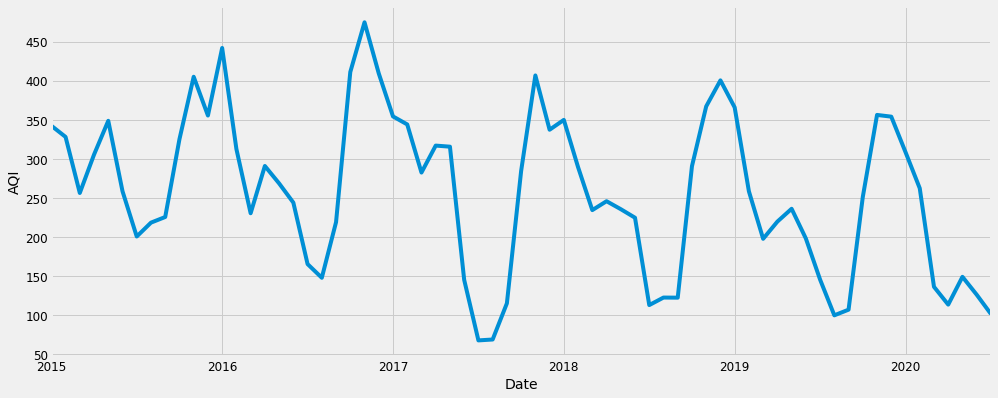

In [40]:
ts_month_avg.plot(figsize=(15, 6))      #plot the resampled data
plt.ylabel("AQI")
plt.show()

##Seasonal Decompose the Data
As we can see from the plot above, the mean and the variance of the data remains same throughout the data. Hence, there is no need to transform the data. We now proceed to check the trend and seasonal components of the data. Each time series can be decomposed into 3 components –



1.   Trend
2.   Seasonality
3.   Noise


Let us see our decomposed time series –

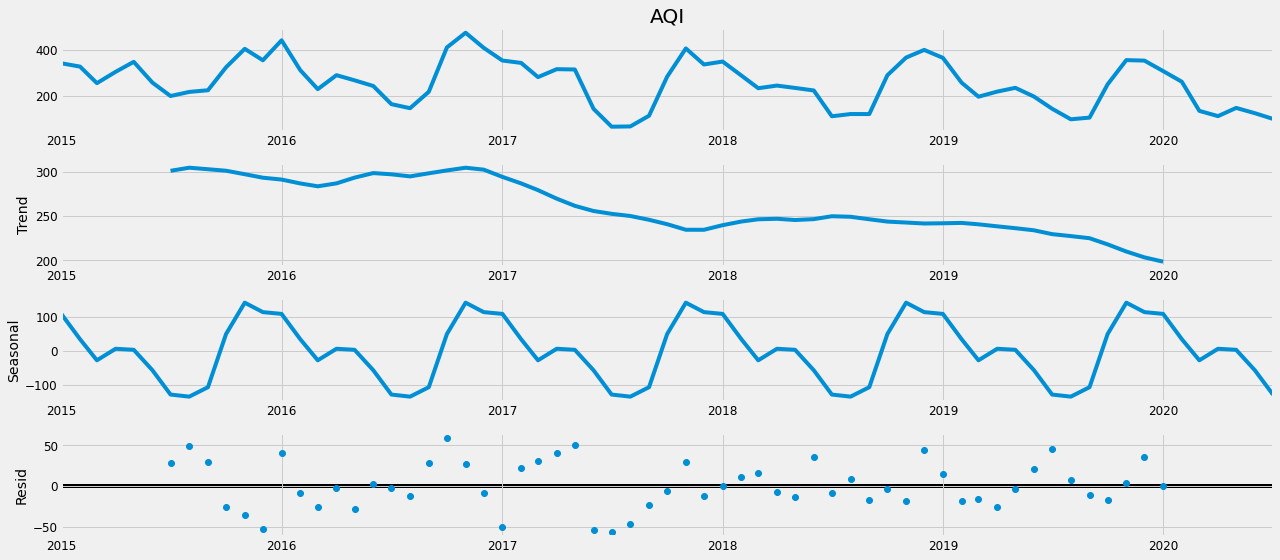

In [41]:
from pylab import rcParams              #import library for rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ts_month_avg, model='additive')     #seasonal decomposing the resampled data
fig = decomposition.plot()                      #plotting the seasonal decomposed data
plt.show()

As we can see, there is a downward trend and an annual seasonality (lag = 12) in the data. We can also verify the presence of seasonality by looking at the ACF plot. It shows spikes at lag values 12, 24, 36, and so on. Therefore the series is not stationary. We have to remove it in order to do the analysis. It will be done by differencing and verified using statistical tests like ADF (for trend)

##Perform ADF and KPSS test

In [42]:
#apply adf and kpss test on the series
print(adf_test(ts_month_avg))
print(kpss_test(ts_month_avg))

Results of Dickey-Fuller Test:
Test Statistic                  0.229024
p-value                         0.973843
#Lags Used                     11.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64
None
Results of KPSS Test:
Test Statistic            0.650669
p-value                   0.018030
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
None


Since the p-value of 0.96 is greater than the critical value of 0.05, we can statistically confirm that the series is not stationary. Hence, we would do first-order differencing for the trend and re-run the ADF test to check for stationarity.

##First order differenciating data

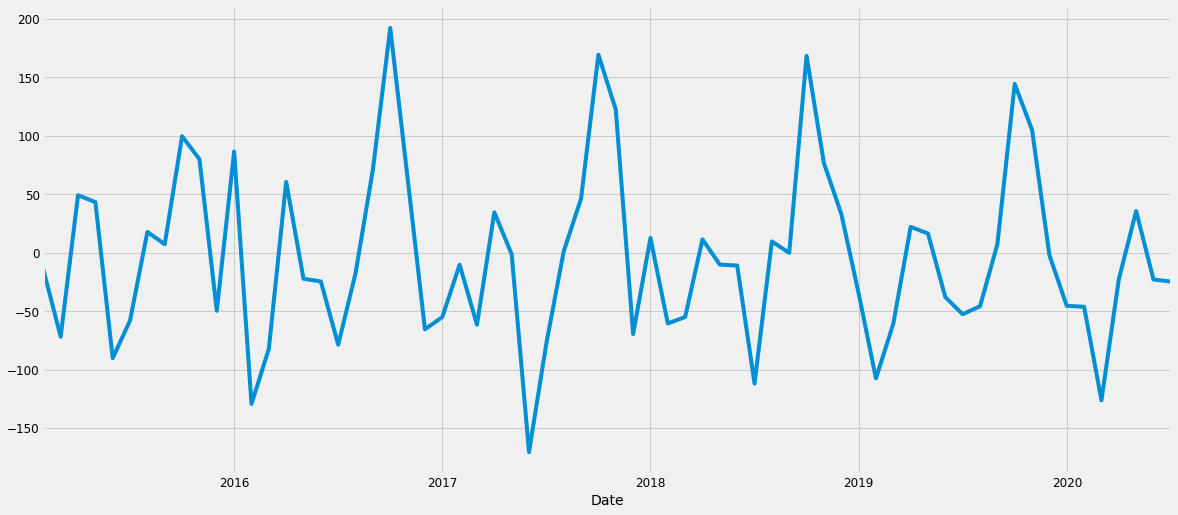

In [43]:
ts_t_adj = ts_month_avg - ts_month_avg.shift(1)   #perform first order differencing on the data
ts_t_adj = ts_t_adj.dropna()                      #remove NAN rows after firs order differencing
ts_t_adj.plot()                                   #plotting the data


The trend now seems to have disappeared from the data. Running the ADF test validates the observation.

###Perform ADF test on differenciated data

In [44]:
#apply adf test on the series
print(adf_test(ts_t_adj))

Results of Dickey-Fuller Test:
Test Statistic                -6.795995e+00
p-value                        2.300252e-09
#Lags Used                     1.000000e+01
Number of Observations Used    5.500000e+01
Critical Value (1%)           -3.555273e+00
Critical Value (5%)           -2.915731e+00
Critical Value (10%)          -2.595670e+00
dtype: float64
None


The p-value is less than the critical value of 0.05. Hence we can confirm that the series is now trend stationary. 

##Remove Seasonality

Let us now move onto seasonal differencing. Since the data is showing an annual seasonality, we would perform the differencing at a lag 12, i.e yearly.

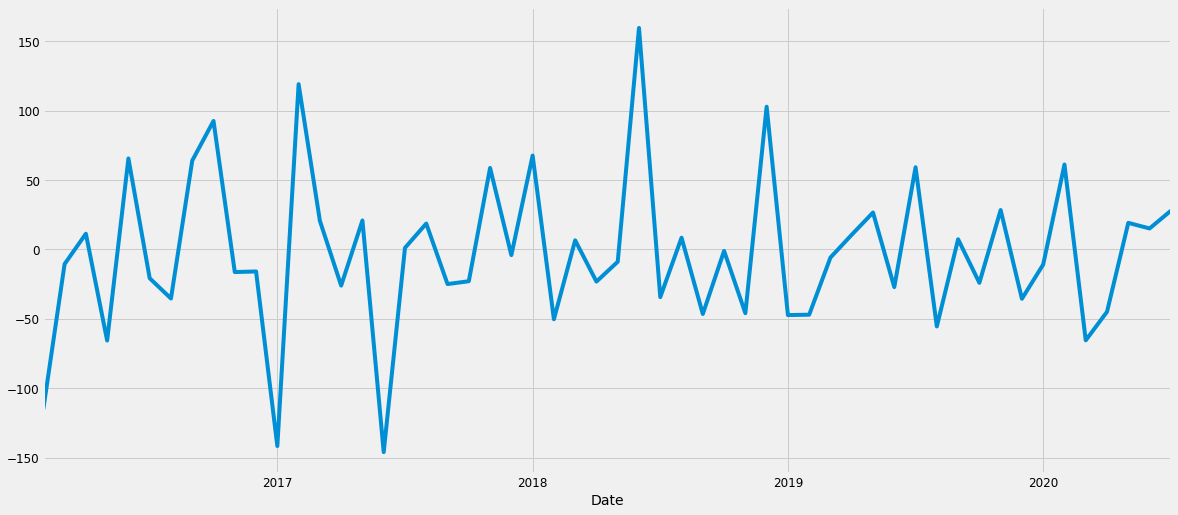

In [45]:
ts_s_adj = ts_t_adj - ts_t_adj.shift(12)
ts_s_adj = ts_s_adj.dropna()
ts_s_adj.plot()

Now that the data are stationary, let us proceed to the next step in the process – the ACF and PACF plots.

##Plot ACF and PACF plots

By now, we have been able to identify 3 out of 7 components for our SARIMA equation. Those are trend differencing order(d), seasonal differencing order(D) and lag = 12. Let us now try and figure out the other 4 components, i.e – p and seasonal P, q and seasonal Q. In order to figure these out, we would need to plot the ACF and PACF plots.

ACF stands for Auto Correlation Function and PACF stands for Partial Auto Correlation Function.

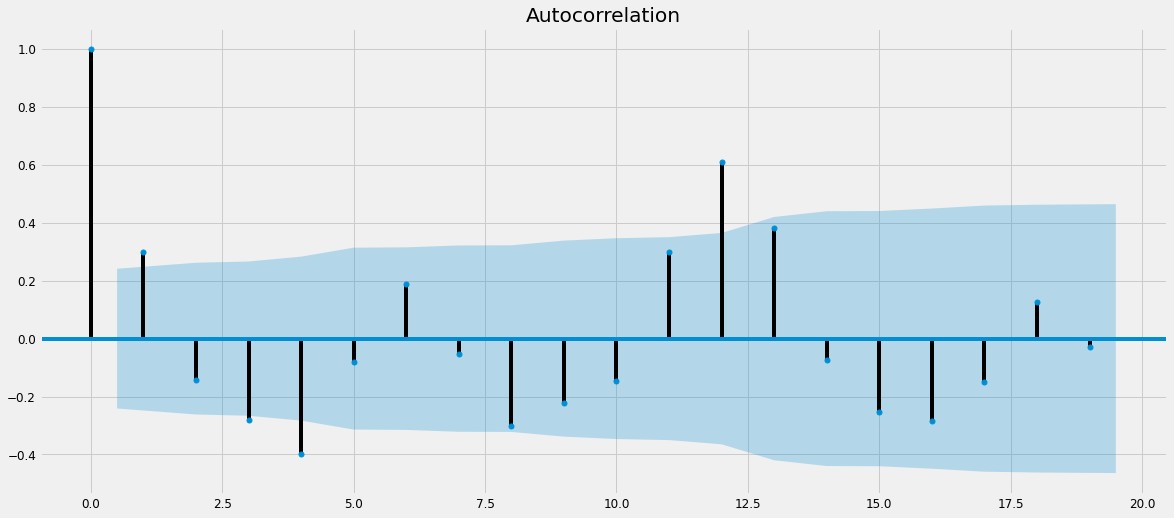

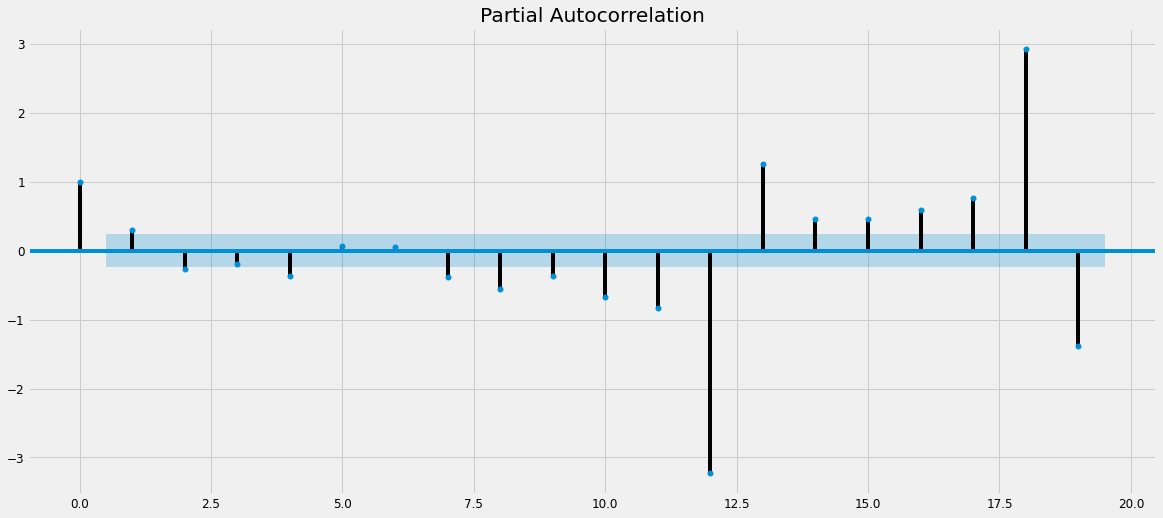

In [46]:
# Plotting the ACF and PACF Plot of the Trend and Seasonally adjusted Time Series data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_t_adj)
matplotlib.pyplot.show()
plot_pacf(ts_t_adj)
matplotlib.pyplot.show()

We can see that –

For ACF plot, initial spikes at lag = 1 and seasonal spikes at lag = 12, which means a probable AR order of 1 and seasonal AR order of 1

For PACF plot, initial spikes at lag = 1 and seasonal spikes at lag = 12, which means a probable MA order of 1 or 2 and seasonal MA order of 1

So, our probable SARIMA model equation can be –

SARIMA(1,1,1)x(1,1,1)12

##Model Creation

Since we are unsure of the exact model equation, we will perform a grid search with the list of possible values around our estimated parameters. We will then pick the model with the least AIC.

In [47]:
p = range(0, 3)           #storing returns a sequence of number from 0 to 2
d = range(1,2)            #storing returns a sequence of number from 1 to 2
q = range(0, 3)           #storing returns a sequence of number from 0 to 2
pdq = list(itertools.product(p, d, q))          #creating list of p,d,q parameters
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]   #creating sample seasonal ARIMA models
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
seasonal_pdq

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)


[(0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12)]

According Peterson, T. (2014) the AIC (Akaike information criterion) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.

In [48]:
#Analysis of the SARIMA using statespace
for param in pdq:           
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_s_adj,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            )
            results = mod.fit(method = 'powell')
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))   #print the AIC of the SARIMA models to identify model with the lowest AIC
        except:
            continue

Optimization terminated successfully.
         Current function value: 4.960489
         Iterations: 2
         Function evaluations: 43
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:537.7328344169001
Optimization terminated successfully.
         Current function value: 4.732679
         Iterations: 2
         Function evaluations: 120
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:515.1293857551273
Optimization terminated successfully.
         Current function value: 4.603874
         Iterations: 6
         Function evaluations: 233
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:503.21839747372917
Optimization terminated successfully.
         Current function value: 4.709652
         Iterations: 3
         Function evaluations: 79
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:512.6424114236052
Optimization terminated successfully.
         Current function value: 4.599030
         Iterations: 4
         Function evaluations: 247
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:502.69526855337887
Optimization terminated successfull

The low AIC value the better.
Our output suggests SARIMA(0, 1, 1)x(2, 1, 0, 12) with AIC of 476.0627 is the best combination, so we should consider this to be optimal option.

##Training the Model

Upon obtaining the model orders from the grid search above, we fit a SARIMA model to our data.

In [49]:

mod = sm.tsa.statespace.SARIMAX(ts_month_avg,
                                order=(0, 1, 1),
                                seasonal_order=(2, 1, 0, 12))       #fitting the dataset into the model using the parameters identified in the above step
results = mod.fit(method = 'powell')                        
print(results.summary().tables[1])              #printing the results of the SARIMA model after fitting the data

Optimization terminated successfully.
         Current function value: 4.229801
         Iterations: 4
         Function evaluations: 196
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1093      0.184     -0.594      0.553      -0.470       0.251
ar.S.L12      -0.7355      0.176     -4.182      0.000      -1.080      -0.391
ar.S.L24      -0.2688      0.198     -1.360      0.174      -0.656       0.119
sigma2      1869.4376    463.279      4.035      0.000     961.427    2777.448


##Residual Check

Once we have a fitted model to the data, it is necessary to check the residual plots to verify the validity of the model fit. A good forecasting method will yield residuals with the following properties:

The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals that should be used in computing forecasts.

The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

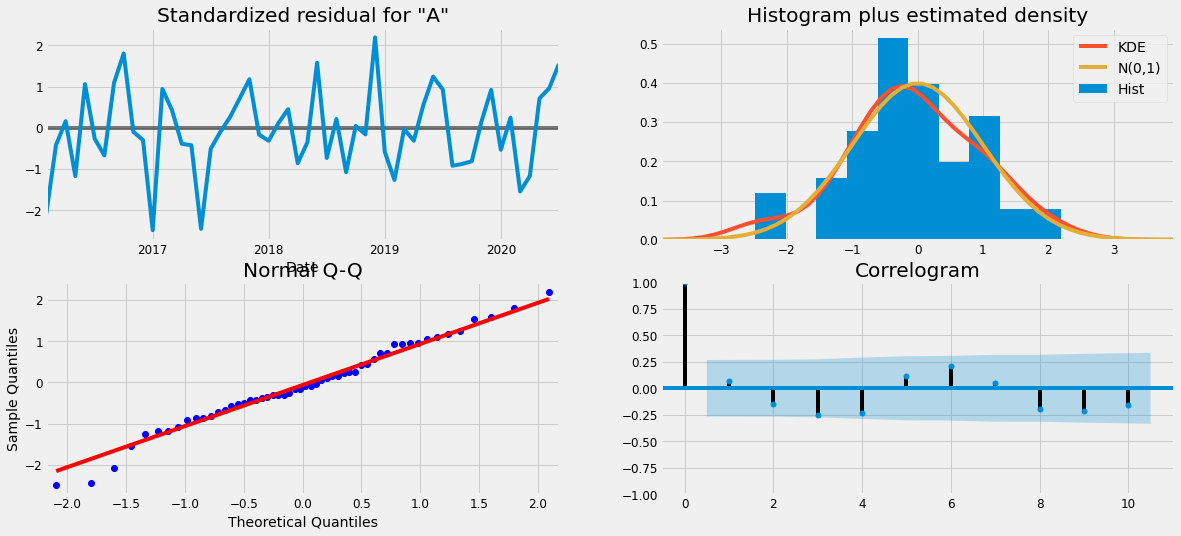

In [50]:
results.plot_diagnostics(figsize=(18, 8))     #plotting the residuals
plt.show()

As we can see from the image above, the residuals are uncorrelated and have zero mean. Hence we can say the model is fitted well.

##Predict using the model



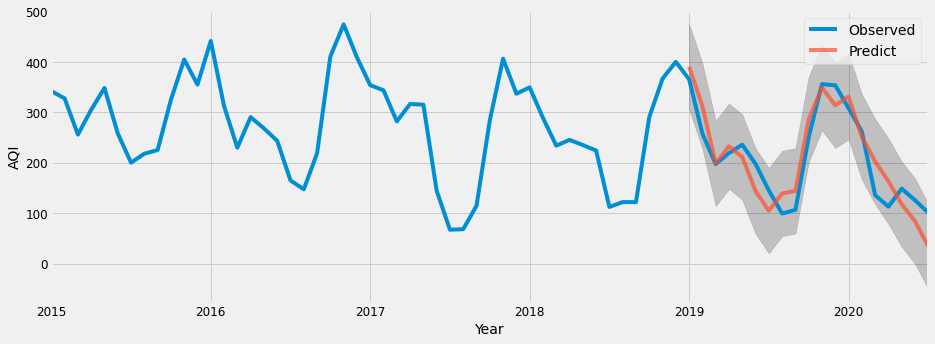

In [51]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)  #make prediction from the date 01-01-2019 onwards
pred_ci = pred.conf_int()                     #Construct confidence interval for the fitted parameters.
ax = ts_month_avg.plot(label='Observed')          #plotting the actual observed data
pred.predicted_mean.plot(ax=ax, label='Predict', alpha=.7, figsize=(14, 5))     #plotting the predicted data
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)      #filling color in the confidence interval
ax.set_xlabel('Year')                                             #labelling the x axis
ax.set_ylabel('AQI')                                               #labelling the y axis
plt.legend()                                                      #showing the legend for the graph
plt.show()                                                        #display the plotted graph

##Evaluate the Model

To evaluate the model performance, we use Root Mean Squared Error (RMSE).

In [53]:
y_forecasted = pred.predicted_mean                  
y_truth = ts_month_avg['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()        #computing the mse
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))   #computing the rsme and displaying

The Mean Squared Error is 1557.29
The Root Mean Squared Error is 39.46


##Forecast using the model

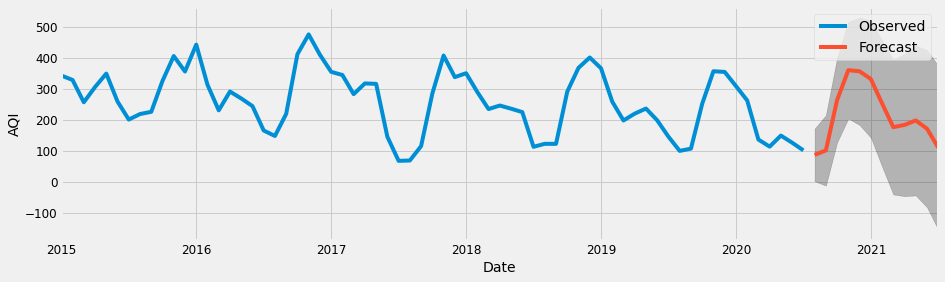

In [55]:
pred_uc = results.get_forecast(steps=12)              #forecasting using the model results
pred_ci = pred_uc.conf_int()                          #Construct confidence interval for the parameters.
ax = ts_month_avg.plot(label='Observed', figsize=(14, 4))     #plotting the observed actual data
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')      #plotting the forecasted data
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)       #adding color to the confidence interval
ax.set_xlabel('Date')                                           #labeling the axis x
ax.set_ylabel('AQI')                                          #labeling the axis y
plt.legend()                                                    #generating the legend for the graph
plt.show()                                                      #display the graph